In [1]:
from pipeline import *


In [2]:
binance = Binance(path='dataset/Binance_DOGEUSDT_1h.csv')
reddit = Reddit(path = 'dataset/final_sorted.csv')

In [3]:
reddit.data

,from,to,time,utc,post.id,comment.id,parent.id,from_moderator,to_moderator
0,Professional_Feed478,Professional_Feed478,2020-12-01 02:05:52,1606784752,k4a18g,k4a18g,k4a18g,False,False
1,Sporklin,Professional_Feed478,2020-12-01 02:24:55,1606785895,k4a18g,ge7onzo,t3_k4a18g,False,False
2,shibe5,Professional_Feed478,2020-12-01 02:44:12,1606787052,k4a18g,ge7qspw,t3_k4a18g,False,False
3,HubertHamster,HubertHamster,2020-12-01 03:19:57,1606789197,k4bdlt,k4bdlt,k4bdlt,False,False
4,AutoModerator,HubertHamster,2020-12-01 03:19:58,1606789198,k4bdlt,ge7usya,t3_k4bdlt,True,False
...,...,...,...,...,...,...,...,...,...
3330330,LEGACYlock,LAG4739,2021-07-31 23:57:23,1627768643,ovd5e0,h78x9gw,t3_ovd5e0,False,False
3330331,Nawmannah,spicytomatopasteanon,2021-07-31 23:57:32,1627768652,ov5r7s,h78xa3j,t1_h78wzcy,False,False
3330332,Ravengm,DistinctEngineering2,2021-07-31 23:58:09,1627768689,ov9uyj,h78xcmh,t1_h77t94e,False,False
3330333,Otherwise_Baby_6930,AFRO-1015,2021-07-31 23:58:44,1627768724,ov5r7s,h78xf3p,t1_h78w9fg,False,False


In [4]:
reddit.data['day'] = pd.to_datetime(reddit.data['time']).dt.normalize()

daily_stats = reddit.data.groupby('day').agg(
    total_edges=('from', 'count'),
    mod_edges=('from_moderator', lambda x: (x | reddit.data.loc[x.index, 'to_moderator']).sum()),
    mod_from_edges=('from_moderator', 'sum'),
    mod_to_edges=('to_moderator', 'sum'),
)

daily_stats['mod_edge_share'] = daily_stats['mod_edges'] / daily_stats['total_edges']

In [6]:
# daily aggregation

In [5]:
daily_stats

,total_edges,mod_edges,mod_from_edges,mod_to_edges,mod_edge_share
day,,,,,
2020-12-01,62,2,2,0,0.032258
2020-12-02,91,1,1,0,0.010989
2020-12-03,102,17,17,0,0.166667
2020-12-04,64,4,4,0,0.062500
2020-12-05,57,2,1,1,0.035088
...,...,...,...,...,...
2021-07-27,5018,208,12,197,0.041451
2021-07-28,4664,204,15,190,0.043739
2021-07-29,3976,139,15,125,0.034960


<Axes: title={'center': 'Number of posts/comments per day'}, xlabel='day'>

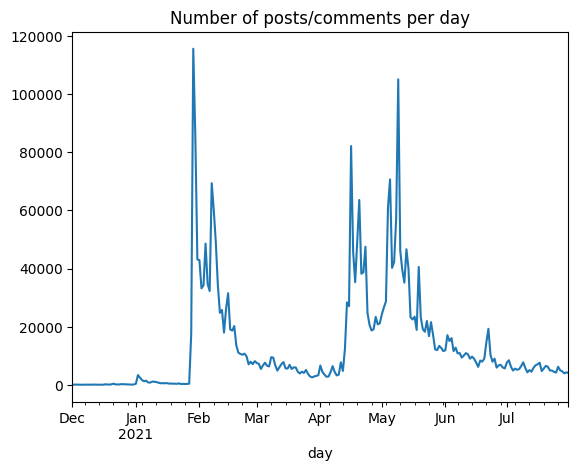

In [9]:
daily_stats['total_edges'].plot(title="Number of posts/comments per day")

<Axes: xlabel='day'>

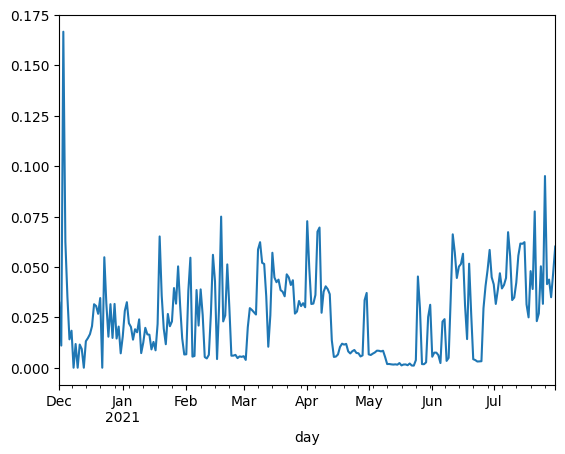

In [10]:
daily_stats['mod_edge_share'].plot()

In [13]:
# Identify spike days (top 1% by mod activity)
daily_mod_counts = daily_stats['mod_from_edges']
threshold = daily_mod_counts.quantile(0.99)
spike_days = daily_mod_counts[daily_mod_counts >= threshold].index

# Pick comparable non-spike days
normal_days = daily_mod_counts[daily_mod_counts < threshold].sample(len(spike_days), random_state=42).index

Function to compute daily network metrics

In [14]:
import networkx as nx
import numpy as np

def compute_daily_metrics(day_df):
    G = nx.from_pandas_edgelist(
        day_df,
        source='from',
        target='to',
        create_using=nx.DiGraph()
    )

    degrees = dict(G.degree())
    total_degree = sum(degrees.values())

    # Map moderator status
    mod_map = (
        day_df[['from', 'from_moderator']]
        .drop_duplicates()
        .set_index('from')['from_moderator']
        .to_dict()
    )

    # Degree held by moderators
    mod_degree = sum(
        deg for node, deg in degrees.items()
        if mod_map.get(node, False)
    )

    # Centralization (Freeman-style, normalized)
    max_deg = max(degrees.values())
    centralization = sum(max_deg - d for d in degrees.values())
    centralization /= (len(degrees) - 1) * (len(degrees) - 2) if len(degrees) > 2 else np.nan

    # Is the most central node a moderator?
    top_node = max(degrees, key=degrees.get)
    top_is_mod = mod_map.get(top_node, False)

    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'centralization': centralization,
        'mod_degree_share': mod_degree / total_degree if total_degree > 0 else 0,
        'top_node_is_mod': top_is_mod
    }

Compute metrics for spike vs normal days

In [19]:
reddit.data['day'] = pd.to_datetime(reddit.data['time']).dt.normalize()

def compute_group_metrics(days, label):
    metrics = []
    for day in days:
        day_df = reddit.data[reddit.data['day'] == day]
        m = compute_daily_metrics(day_df)
        m['day'] = day
        m['type'] = label
        metrics.append(m)
    return pd.DataFrame(metrics)

spike_metrics = compute_group_metrics(spike_days, 'spike')
normal_metrics = compute_group_metrics(normal_days, 'normal')

metrics = pd.concat([spike_metrics, normal_metrics])

Compare spike vs normal days

In [21]:
metrics.groupby('type')[[
    'centralization',
    'mod_degree_share',
    'top_node_is_mod'
]].mean()

,centralization,mod_degree_share,top_node_is_mod
type,,,
normal,0.298967,0.011226,0.0
spike,0.199157,0.015770,0.0


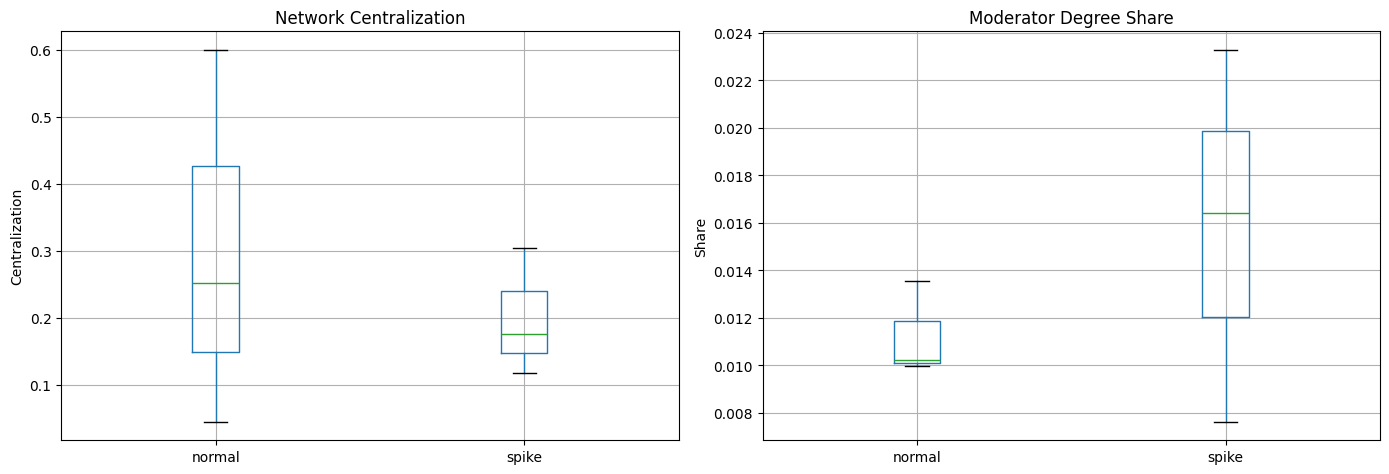

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14,5))

metrics.boxplot(
    column='centralization',
    by='type',
    ax=axs[0]
)
axs[0].set_title('Network Centralization')
axs[0].set_xlabel('')
axs[0].set_ylabel('Centralization')

metrics.boxplot(
    column='mod_degree_share',
    by='type',
    ax=axs[1]
)
axs[1].set_title('Moderator Degree Share')
axs[1].set_xlabel('')
axs[1].set_ylabel('Share')

plt.suptitle('')
plt.tight_layout()
plt.show()

Betweenness based daily metric function

In [24]:
import networkx as nx
import numpy as np

def compute_daily_betweenness_metrics(day_df):
    # Build directed graph
    G = nx.from_pandas_edgelist(
        day_df,
        source='from',
        target='to',
        create_using=nx.DiGraph()
    )

    if G.number_of_nodes() < 3:
        return {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'mod_betweenness_share': np.nan,
            'top_betweenness_is_mod': np.nan
        }

    # Betweenness centrality (normalized)
    betw = nx.betweenness_centrality(G, normalized=True)

    # Moderator mapping
    mod_map = (
        day_df[['from', 'from_moderator']]
        .drop_duplicates()
        .set_index('from')['from_moderator']
        .to_dict()
    )

    total_betw = sum(betw.values())

    # Betweenness held by moderators
    mod_betw = sum(
        b for node, b in betw.items()
        if mod_map.get(node, False)
    )

    # Top betweenness node
    top_node = max(betw, key=betw.get)
    top_is_mod = mod_map.get(top_node, False)

    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'mod_betweenness_share': mod_betw / total_betw if total_betw > 0 else 0,
        'top_betweenness_is_mod': top_is_mod
    }

Compute for spike vs normal (takes like 3 mins)

In [28]:
from tqdm import tqdm
def compute_betweenness_group(days, label):
    metrics = []
    for day in tqdm(days):
        day_df = reddit.data[reddit.data['day'] == day]
        m = compute_daily_betweenness_metrics(day_df)
        m['day'] = day
        m['type'] = label
        metrics.append(m)
    return pd.DataFrame(metrics)

spike_betw = compute_betweenness_group(spike_days, 'spike')
normal_betw = compute_betweenness_group(normal_days, 'normal')

betw_df = pd.concat([spike_betw, normal_betw])

 33%|███▎      | 1/3 [19:38<39:16, 1178.10s/it]


KeyboardInterrupt: 

In [ ]:
betw_df.groupby('type')[[
    'mod_betweenness_share',
    'top_betweenness_is_mod'
]].mean()

In [ ]:
import matplotlib.pyplot as plt

betw_df.boxplot(
    column='mod_betweenness_share',
    by='type',
    figsize=(8,5)
)

plt.title('Moderator Betweenness Share')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Share of Total Betweenness')
plt.tight_layout()
plt.show()